Para hacer un algoritmo genético tenemos que definir:
- Una representación del genotipo de un individuo
  - Teniendo en mente que esto es lo que se va a heredar, mutar y cruzar entre individuos
- Fenotipo
  - La representación visual que se ve en un individuo
- Función de fitness
  - Es lo que nos dice qué tan cercano al resultado final es un individuo
- Forma de realizar el cruce
  - Cómo se van a combinar los cromosomas de los padres?
  - Tipos: cruce de un punto, cruce de dos puntos, cruce uniforme...
- Forma de realizar la mutación
  - Qué tanto vamos a mutar los genes de un individuo
- Estrategia de reemplazo
  - Cómo se reemplazan los individuos de cada generación?
  - Tipos: generacional, elitista.

# Fenotipo y genotipo
Nuestro **fenotipo** va a ser la imagen generada que nosotros como humanos podemos ver, si ese es nuestro fenotipo, entonces el genotipo tienen que ser primitivas a partir de las cuales se saque/calcule/genere el fenotipo.

Basado en diferentes ejemplos de repositorios y aplicaciones que realizan
proyectos similares, parece que lo mejor es elegir como genotipo una especificación
de figuras geométricas.

De manera que vamos a tener los siguientes genes:
1. Cantidad de cuadrados
2. Lista de cuadrados
   - Posiciones de sus vértices
   - Color 

In [55]:
from PIL import Image, ImageDraw, ImageChops, ImageColor

canvas_size = (50, 50)
def make_fenotype(genotype):
    canvas = Image.new("RGB", canvas_size, ImageColor.getrgb("white"))
    draw = ImageDraw.Draw(canvas, "RGBA")
    for figure in genotype.figures:
        draw.rectangle(
            [figure.initial_point, figure.end_point], fill=figure.color)
    canvas.save("fenotype.png")
    return canvas

In [56]:
class MyRect:
    def __init__(self, initial_point:tuple[int, int], 
                 end_point:tuple[int, int], color:tuple[int, int, int])-> None:
        self.initial_point = initial_point
        self.end_point = end_point
        self.color = color

class Genotype:
    def __init__(self, figure_quantity: int, figures: list[MyRect]) -> None:
        self.figure_quantity = figure_quantity
        self.figures = figures

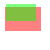

In [57]:
# Ejemplo de un genotipo y su correspondiente fenotipo
genotype = Genotype(2, [
    MyRect((5, 7), (40, 30), (255, 0, 0, 127)),
    MyRect((6, 4), (35, 20), (0, 255, 0, 127))
])

fenotype = make_fenotype(genotype)
display(fenotype)

# Fitness
Necesitamos una función que sea capaz de comparar dos imágenes.

Existen varias alternativas para esto:
- MSE (Mean Squared Error): Esta métrica compara los píxeles individuales de las dos imágenes y calcula el promedio de las diferencias cuadráticas entre los valores de píxeles correspondientes. Cuanto menor sea el valor de MSE, más similares serán las imágenes.
- PSNR (Peak Signal-to-Noise Ratio): Es una métrica que mide la calidad de una imagen comparando la señal (la imagen objetivo) con el ruido (la diferencia entre la imagen objetivo y la generada). Cuanto mayor sea el valor de PSNR, más se parecerán las imágenes.
- SSIM (Structural Similarity Index): Esta métrica evalúa la similitud estructural entre dos imágenes, teniendo en cuenta la luminancia, el contraste y la estructura. SSIM proporciona un valor entre -1 y 1, donde 1 indica una similitud perfecta.
- Cosine Similarity: Esta métrica mide la similitud coseno entre los vectores de píxeles de las dos imágenes. Puede ser útil si deseas comparar la similitud entre imágenes en espacios de características.

Inicialmente intentaremos con SSIM por ser más parecido a cómo los humanos comparamos
imágenes.


In order to not make the wheel again, we will be using pip package pyssim
to compare images, [this is the repo](https://github.dev/jterrace/pyssim)

In [58]:
import ssim
ssim.compute_ssim(fenotype, fenotype)

1.0

# Cruces
Iniciaremos con el más sencillo de los cruces: Cruce de un punto, y haremos
la operación de cruce paramétrica, para así poder cambiarla después de ser 
necesario para la experimentación.

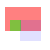

In [59]:
genotype_1 = genotype
genotype_2 = Genotype(3, [
    MyRect((5, 7), (40, 30), (255, 0, 0, 127)),
    MyRect((10, 20), (20, 30), (0, 255, 0, 127)),
    MyRect((20, 20), (40, 40), (0, 0, 255, 30))]
)
fenotype_2 = make_fenotype(genotype_2)
display(fenotype_2)

In [60]:
import random

def one_point_crossover(genotype1: Genotype, genotype2: Genotype) -> Genotype:
    son_figure_quantity = random.choice([genotype1.figure_quantity,
                                         genotype2.figure_quantity])
    crossover_point = random.randint(0, son_figure_quantity)

    parent1_figures = genotype1.figures[:crossover_point]

    if genotype1.figure_quantity < crossover_point:
        figures_difference = crossover_point - genotype1.figure_quantity
        crossover_point = crossover_point - figures_difference
    
    parent2_figures = genotype2.figures[crossover_point:]

    parent1_figures = genotype1.figures[:crossover_point]
    son_figures = parent1_figures + parent2_figures
    return Genotype(son_figure_quantity, son_figures)

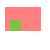

In [61]:
genotype_3 = one_point_crossover(genotype_2, genotype_1)
fenotype_3 = make_fenotype(genotype_3)
display(fenotype_3)

# Mutacion
La mutación como tal involucra dos hiper-parámetros:
- Probabilidad de mutación: Debería ser la probabilidad de que cada gen mute
- Cantidad de mutación: Debería ser la desviación en la que se aleja del valor
  original el gen una vez que muta


In [62]:
import math
mutation_chance = 0.8 # For this test set it high so we see high proability of mutation
mutation_quantity = 0.2 

def mutate_int(value: int) -> int:
    upper_value = math.floor(value + mutation_quantity * value)
    lower_value = math.floor(value - mutation_quantity * value)
    if lower_value < 0:
        lower_value = 0
    return random.randint(lower_value, upper_value)

def mutate_point(point: tuple[int, int]) -> tuple[int, int]:
    x, y = point
    x = mutate_int(x)
    y = mutate_int(y)
    return (x, y)

def mutate_color(color: tuple[int, int, int]) -> tuple[int, int, int]:
    r, g, b, a = color
    r = mutate_int(r)
    g = mutate_int(g)
    b = mutate_int(b)
    a = mutate_int(a)
    return (r, g, b, a)

def mutate(genotype: Genotype) -> Genotype:
    mutate_figure_quantity = random.random() < mutation_chance
    if mutate_figure_quantity:
        genotype.figure_quantity = mutate_int(genotype.figure_quantity)
    
    for figure in genotype.figures:
        mutate_figure_shape = random.random() < mutation_chance
        if mutate_figure_shape:
            figure.initial_point = mutate_point(figure.initial_point)
            figure.end_point = mutate_point(figure.end_point)
        
        mutate_figure_color = random.random() < mutation_chance
        if mutate_figure_color:
            figure.color = mutate_color(figure.color)

    return genotype

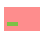

In [73]:
mutated_genotype3 = mutate(genotype_3)
mutated_fenotype3 = make_fenotype(mutated_genotype3)
display(mutated_fenotype3)

# Estrategia de reemplazo
Esto también debería ser un hiperparámetro.
Iniciaremos con la que intuitivamente debería dar mejores resultados: elitista.

Mantendremos al top 30% (que esto puede variar) de mejores individuos de la
generación anterior.